# Supplemental Material: The Ising Model

Suppose we have a square lattice where each site $i$ has a spin $s_i = \pm 1$, representing an atom whose magnetic field is pointed up or down. Each spin interacts with its neighbors, giving the system an overall energy

$$E = - \sum_{ij} s_i s_j,$$

where the sum is over pairs of sites $i,j$ that are nearest neighbors. If we just want to minimize $E$, we can point the spins in the same direction (ferromagnetic model). But system is not always in its lowest energy state --- depending on the temperature, its energy is sometimes higher. According to the _Boltzmann distribution_, the equilibrium probability $P_{eq}(s)$ that a system is in a given state $s$

$$P_{eq}(s) \propto e^{-\beta E(s)}, \quad \text{where } \beta = 1/T$$

and $E(s)$ is an energy of a state $s$. If $T \rightarrow 0, \; \beta \rightarrow \infty$ and $P_{eq}(s)$ is non-zero only for the lowest energy states. In the opposite case $T \rightarrow \infty, \; \beta \rightarrow 0$ and all states are equally likely.

Let's lump states with the same energy together into _macrostates_. Then the total probability of being in a macrostate with energy $E$ is proportional to

$$W e^{-\beta E} = e^{S- \beta E} = e^{-\beta (E-TS)},$$

where $W$ is the number of states in that macrostate. $S = \log W$ is called the entropy. The likeliest macrostate minimizes the free energy $E-TS$.

Now suppose that we want to generate a random state of the Ising model according to the Boltzmann distribution (to estimate some physical quantity $X$ by generating a large number of such states). A naive approach would be to use _rejection sampling_, i.e. setting each spin randomly with equal probability, calculate the energy $E$ of this state and then accept it as a sample with probability $P=e^{-\beta (E - E_{min})}$ (we substract $E_{min}$, so $P \leq 1$). However, for almost all states $P$ is exponentially small, so we would have to generate an exponential number of trial states. It would be much better **to take the Boltzmann factor into acoount during the process of constructing each state**.

## Metropolis-Hastings dynamics (Glauber Algorithm)

We start from initial state (e.g. all spins pointed up or all spins are random) and then perform a random walk in state space, flipping one spin at a time. By defining probabilities of these flips in the right way, we can guarantee that the resulting state will be chosen according to the Boltzmann distribution (after a sufficient time).

At each step we choose the random site $i$ and consider what change $\Delta E$ in the energy would result if we flipped $s_i$. Then we flip $s_i$ with the following probability:

$$ p(\text{flip}) = \begin{cases}
   1 &\text{if $\Delta E < 0$}\\
   e^{-\beta \Delta E} &\text{if $\Delta E \geq 0$.}
 \end{cases} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numba import jit

In [27]:
@jit(nopython=True)
def ising(L, beta, Time):
    x_p = np.full(L*L, np.nan) # Points for the plot
    y_p = np.full(L*L, np.nan)
    x_m = np.full(L*L, np.nan)
    y_m = np.full(L*L, np.nan)

    sample = np.ones((L,L)) # initial sample

    #random initial condition
    for i in range(L):
        for j in range(L):
            if np.random.random(1) < 0.5:
                sample[i,j] = - 1
            else:
                sample[i,j] = 1

    def elem(p, q): # periodic boundary condition
        if p == -1:
            p = L - 1
        elif p == L:
            p = 0            
        if q == -1:
            q = L - 1
        elif q == L:
            q = 0
        return sample[p, q]

    def delta_E(i, j): # computing delta_E
        return 2 * (elem(i - 1, j) + elem(i + 1, j) + elem(i, j - 1) + elem(i, j + 1))

    # Mixing chain

    for t in range(4 * Time):            
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        dE = delta_E(i,j)
        prob = np.exp(beta * dE) / (1 + np.exp(beta * dE))
        if prob < np.random.random(1):
            sample[i, j] = -1
        else:
            sample[i, j] = 1
    
    E = 0.0
    
    # Vizualisation
    k = 0
    l = 0

    for i in range(L):
        for j in range(L):
            if sample[i, j] == 1:
                x_p[k] = i
                y_p[k] = j
                k += 1
            else:
                x_m[l] = i
                y_m[l] = j
                l += 1

    x_p = x_p[x_p != np.nan]
    x_m = x_m[x_m != np.nan]
    y_p = y_p[y_p != np.nan]
    y_m = y_m[y_m != np.nan]
    return x_p, y_p, x_m, y_m, E

In [24]:
L = 32 # square lattice L
Time = L*L*L*L # number of steps (set L*L and 500*L*L and L^4)
beta = 0.95 # 1/T, critical value = 0.44 (change: 0.01 -> 0.44 -> 0.95)

x_p, y_p, x_m, y_m, E = ising(L, beta, Time)

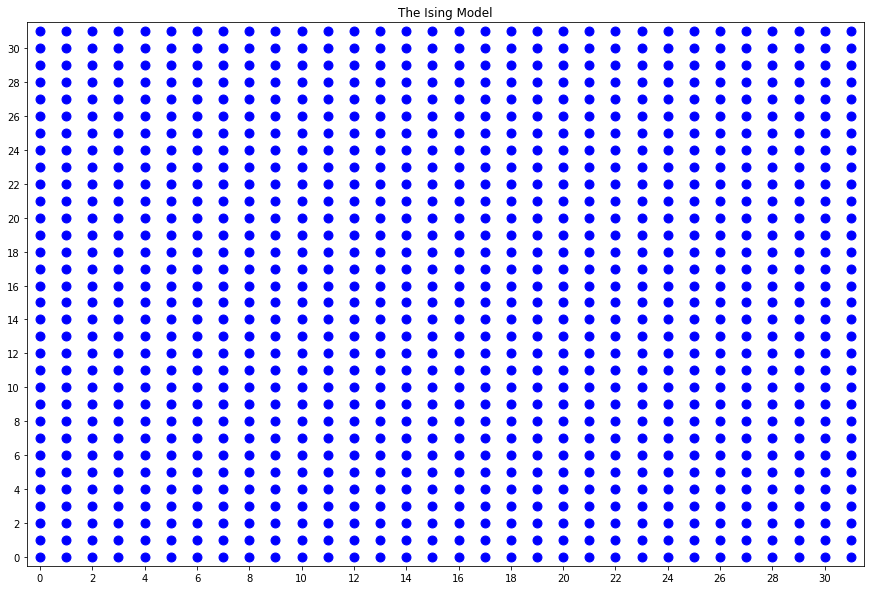

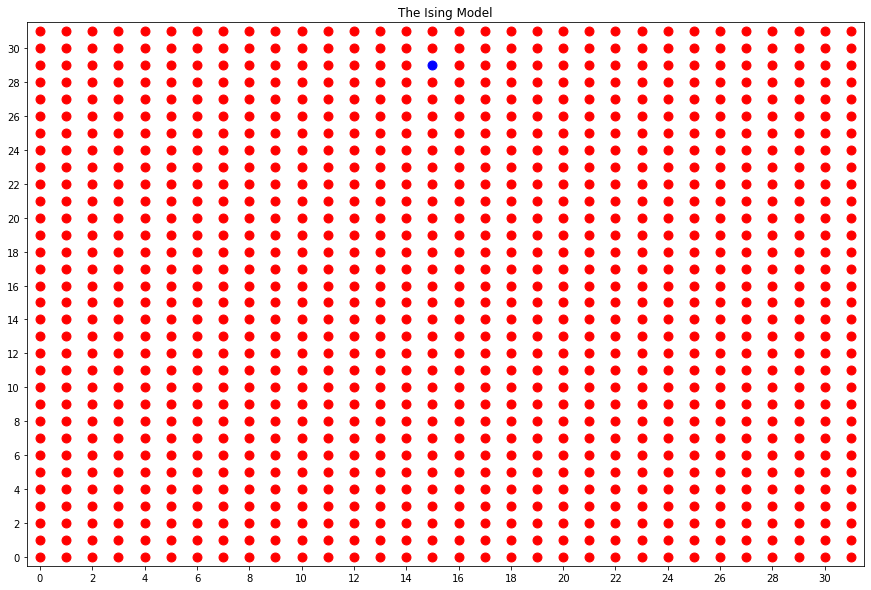

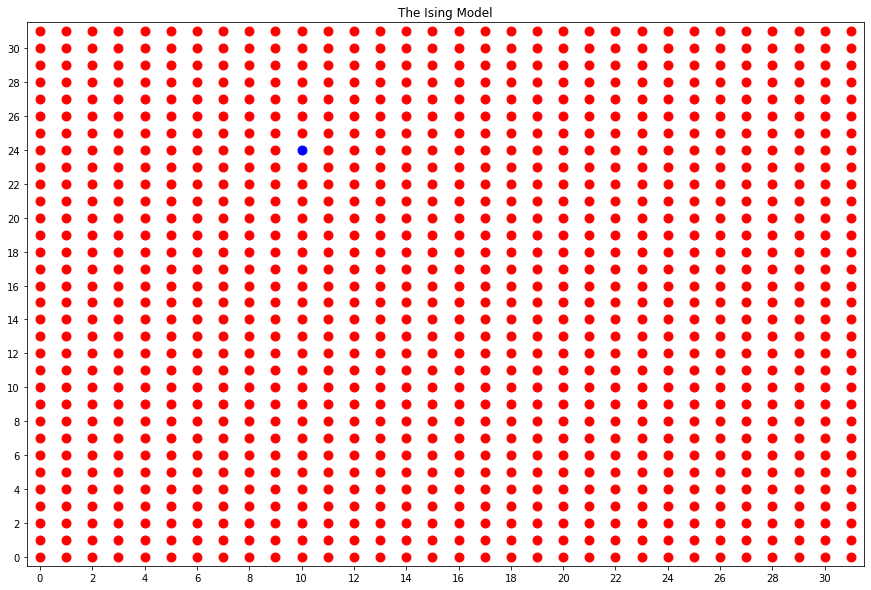

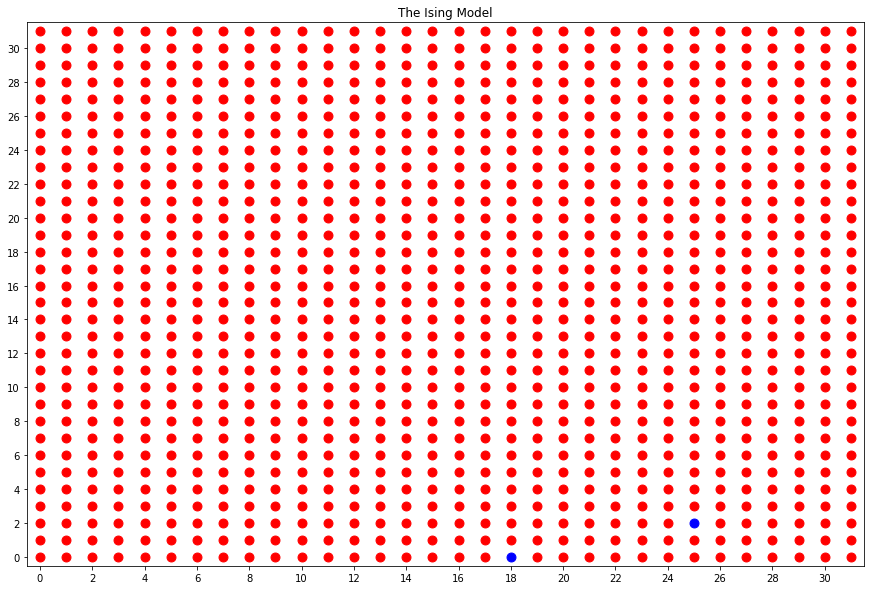

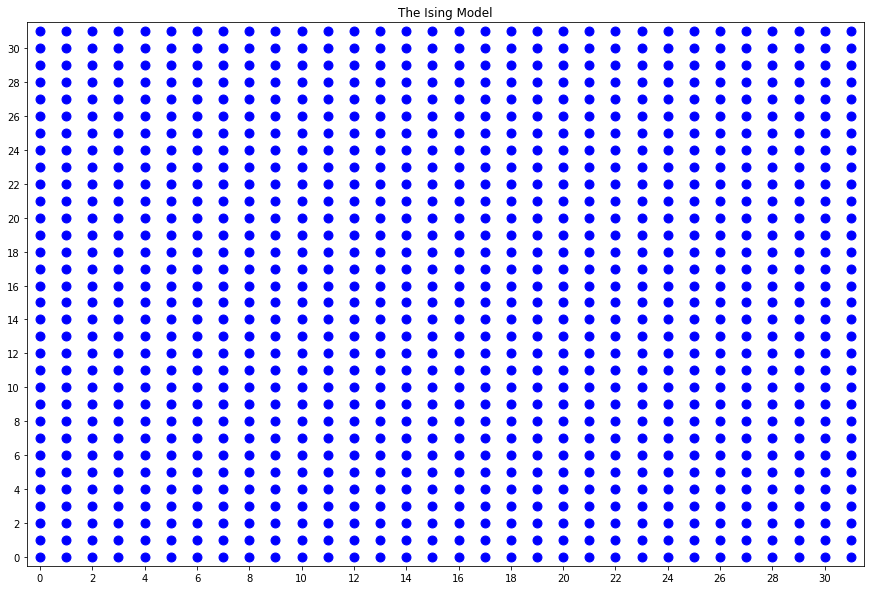

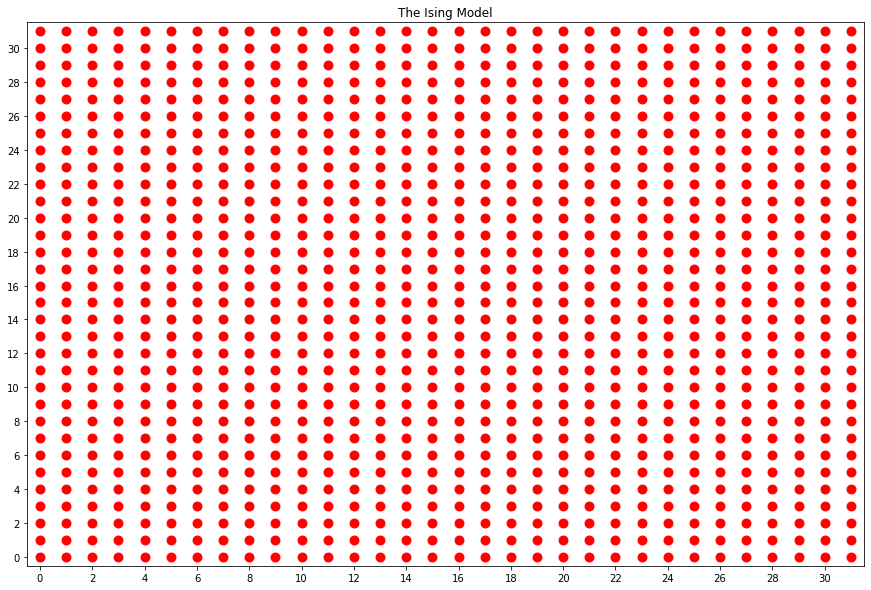

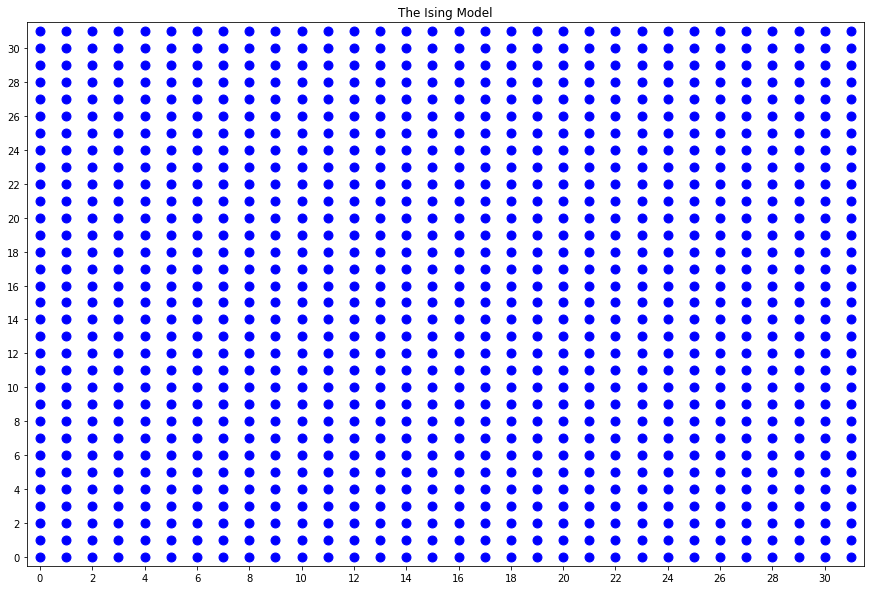

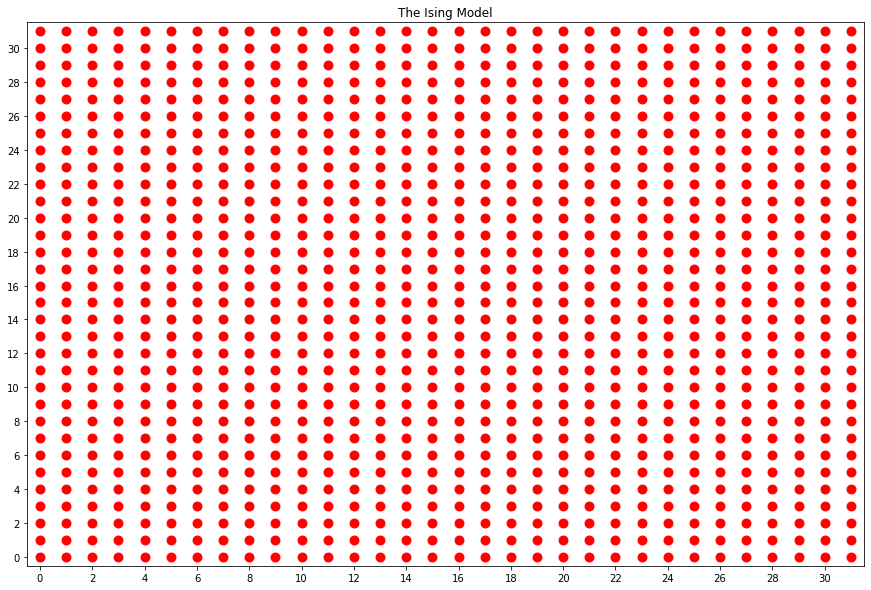

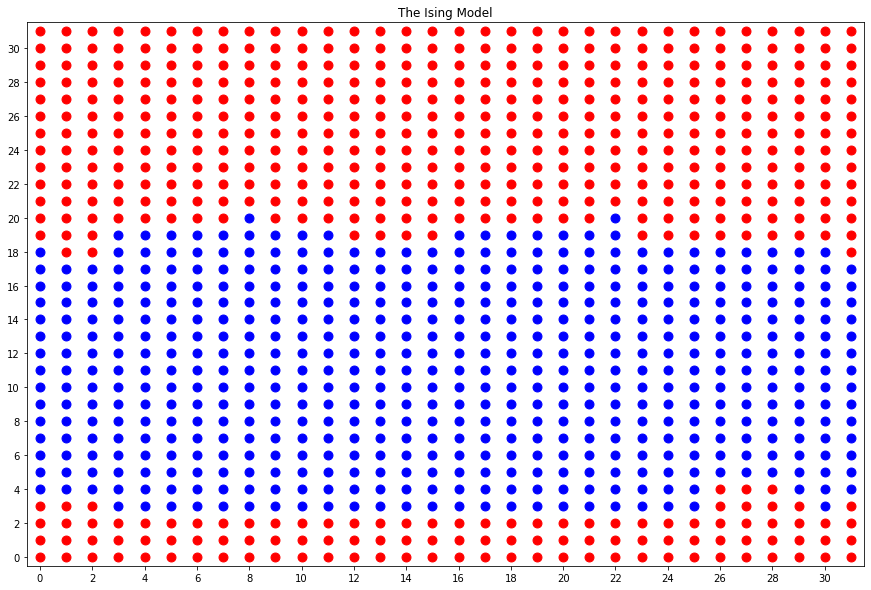

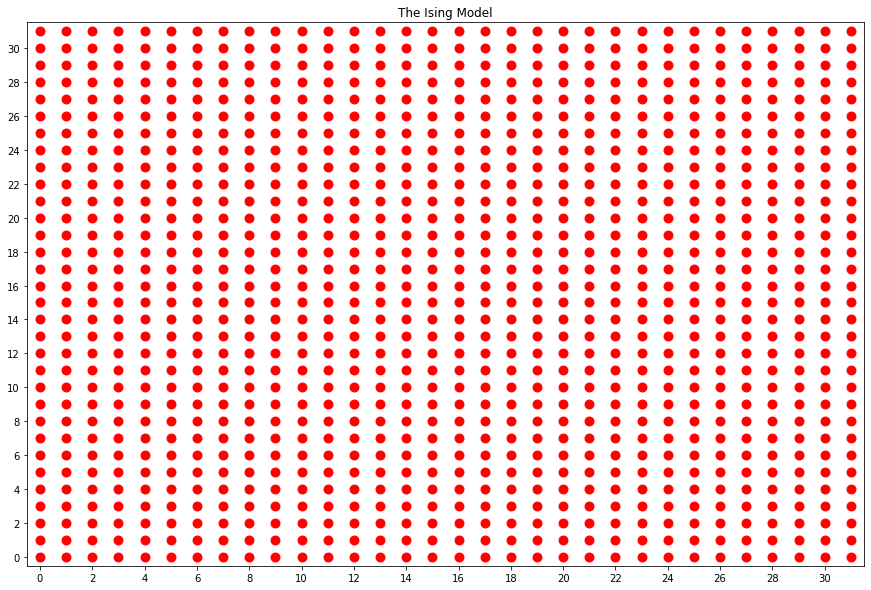

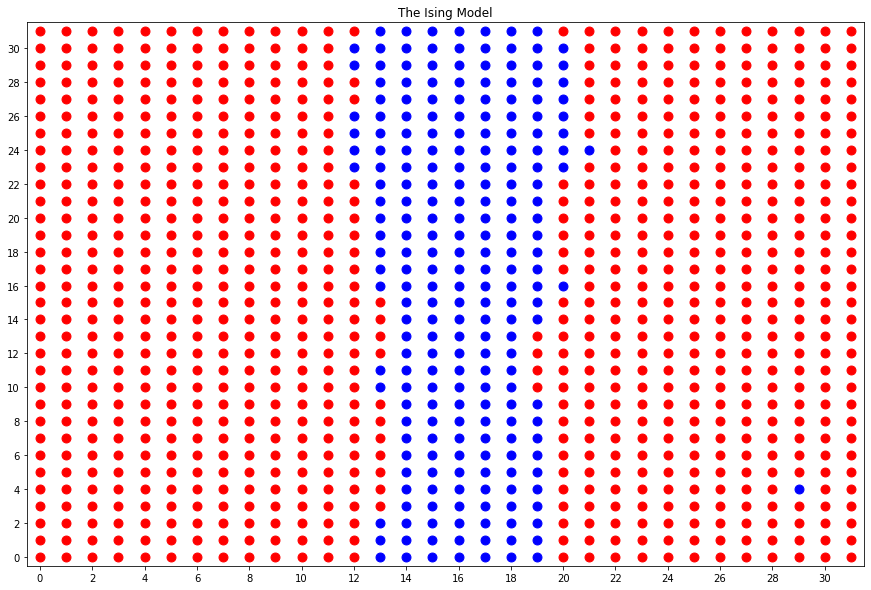

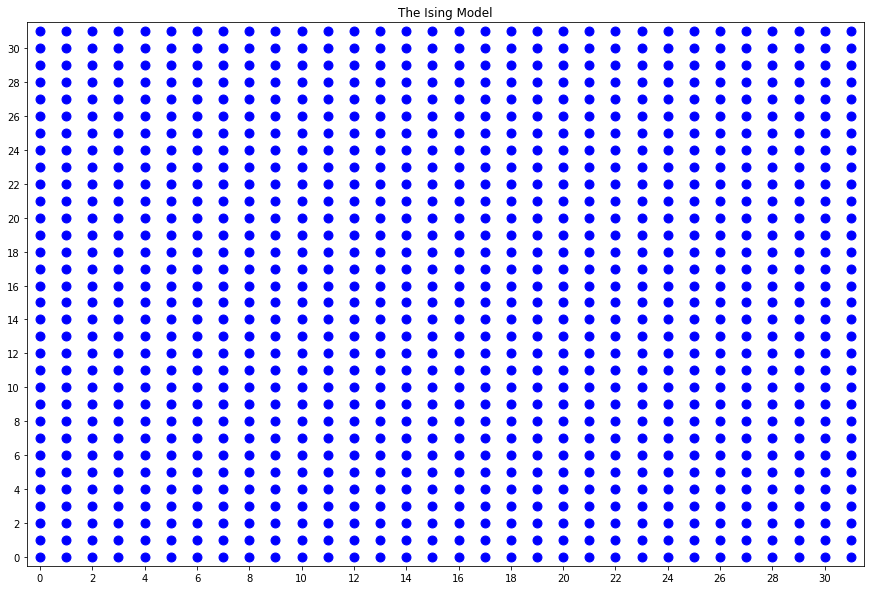

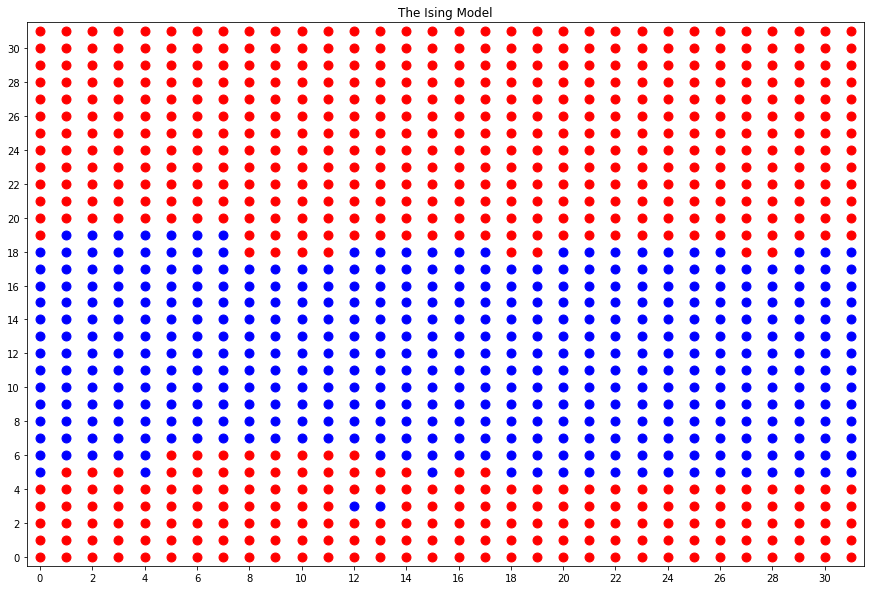

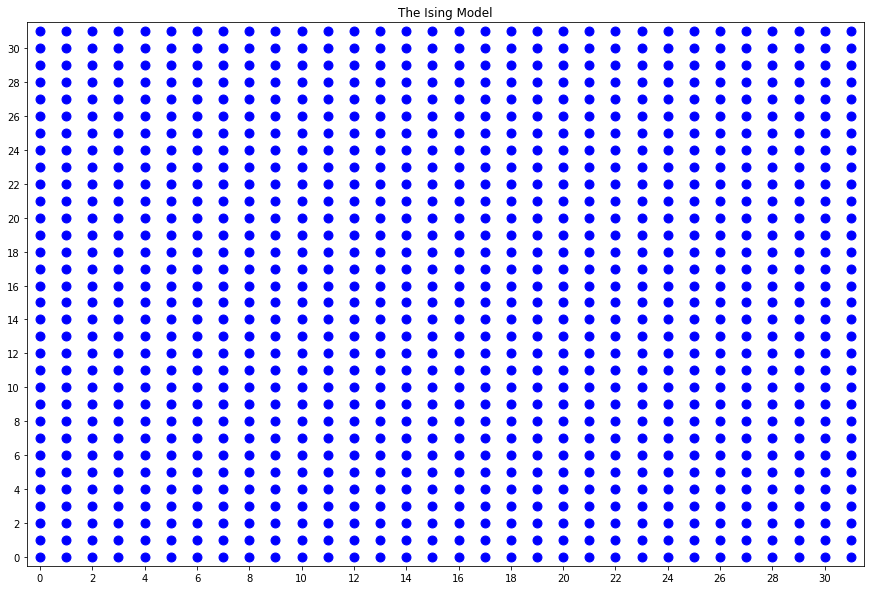

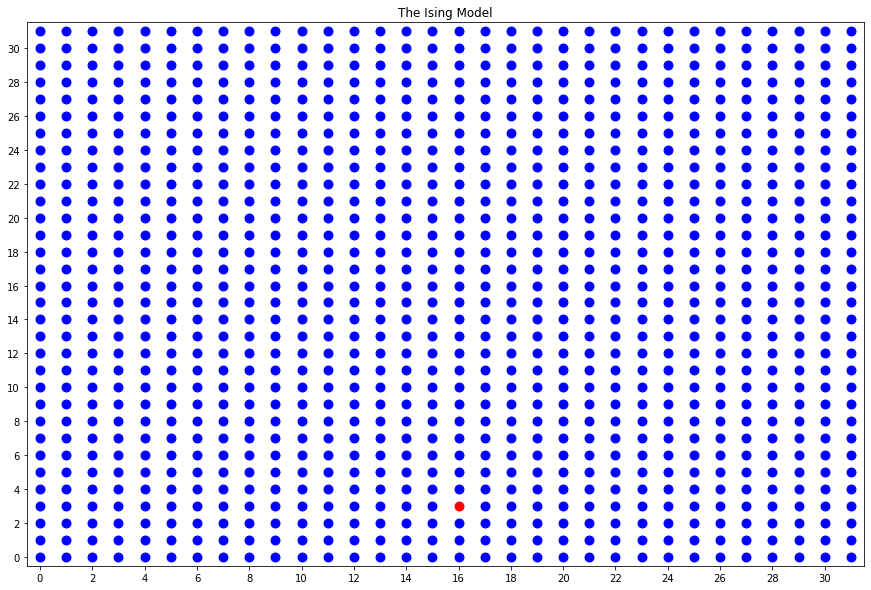

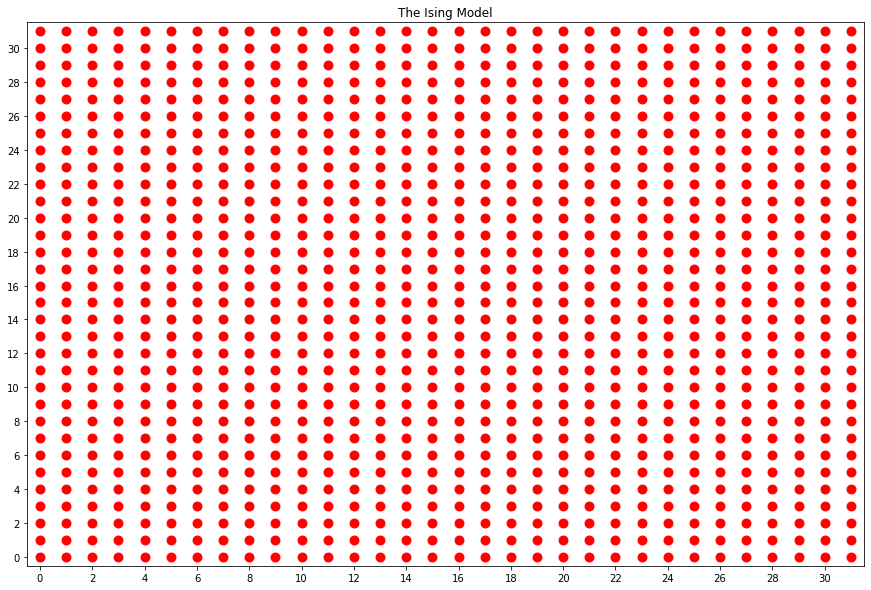

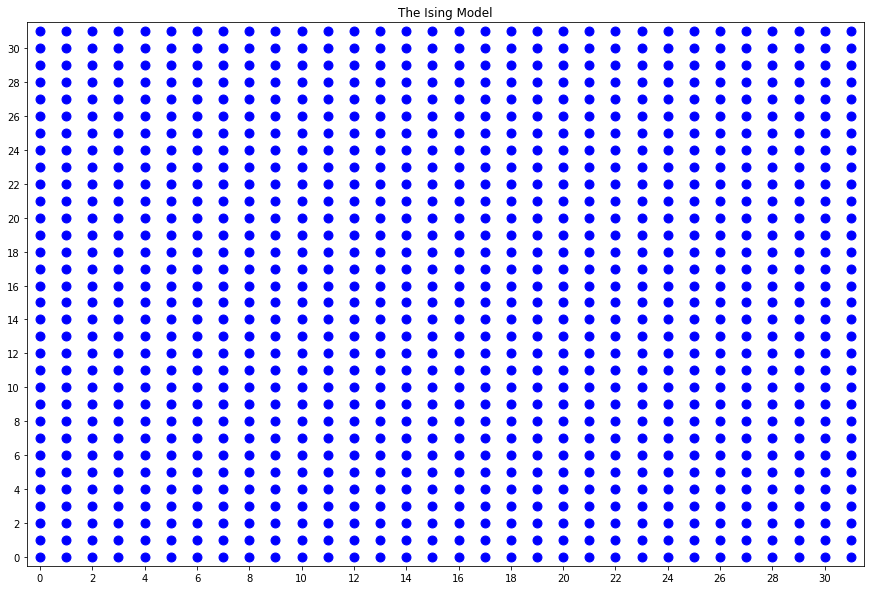

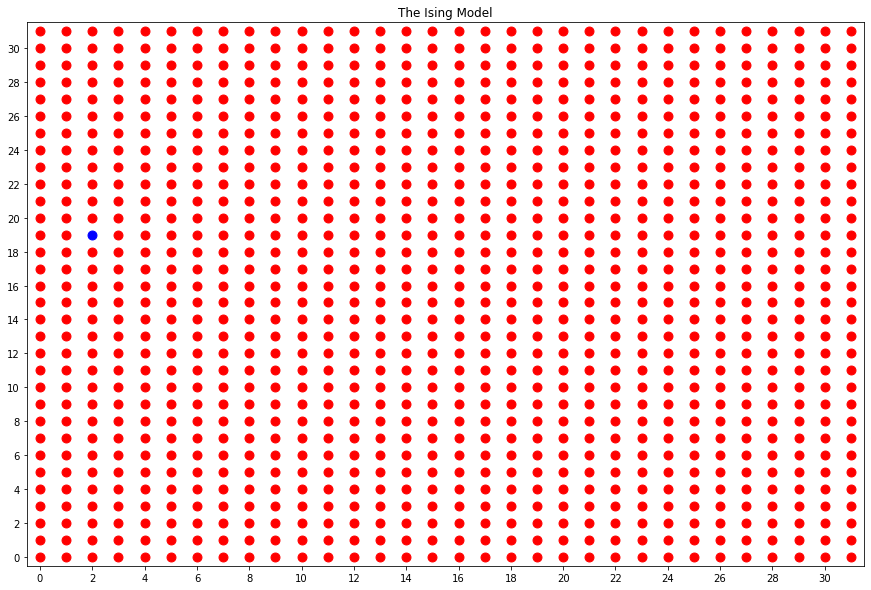

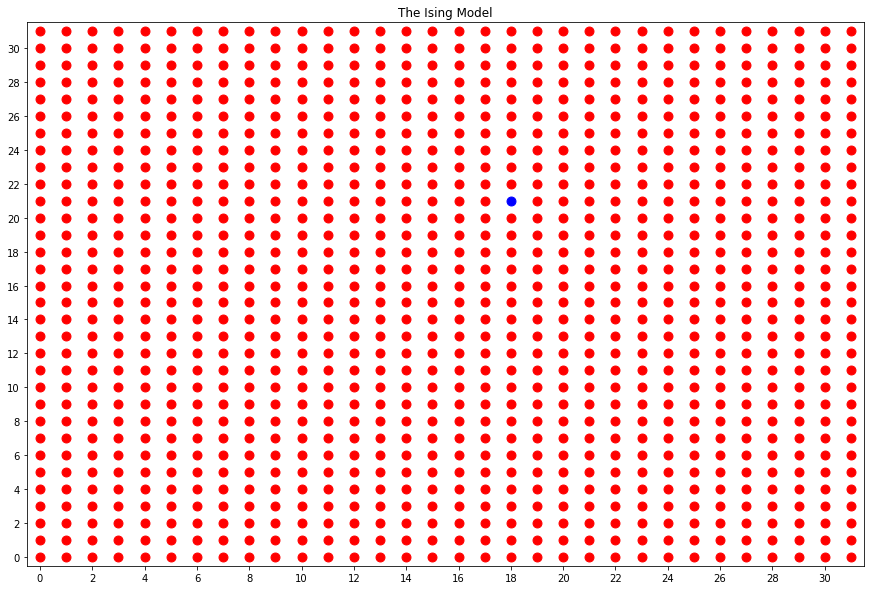

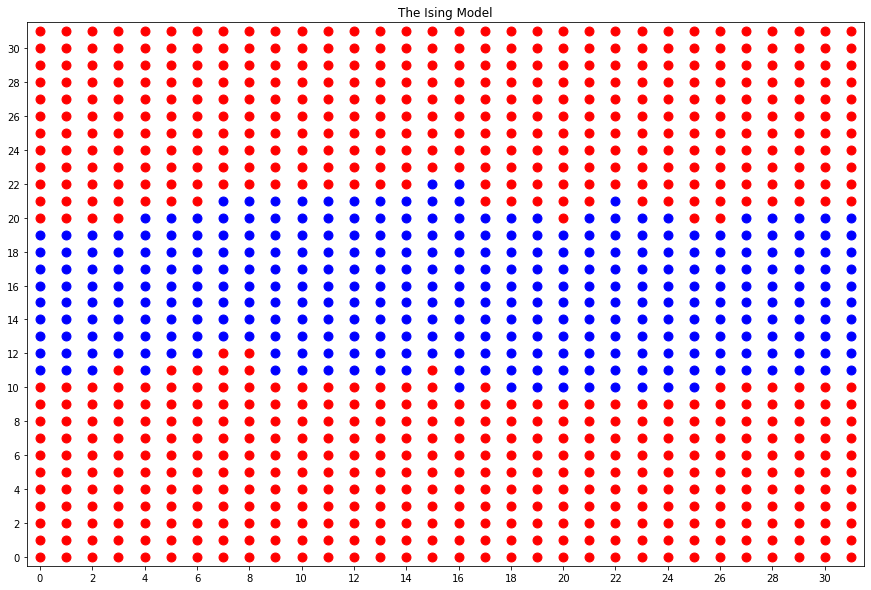

In [28]:
#print("Magnetization: ", M)
#print("Energy: ", E / L**2)
#print('Beta:', beta)
for i in range(20):
    x_p, y_p, x_m, y_m, E = ising(L, beta, Time)
    plt.figure(figsize = (15,10))
    plt.xlim(-0.5, L - 0.5)
    plt.ylim(-0.5, L - 0.5)
    plt.scatter(x_m, y_m, color = "red", s = 2.5 * L)
    plt.scatter(x_p, y_p, color = "blue", s = 2.5 * L)
    plt.title("The Ising Model")
    plt.xticks(np.arange(0, L, 2))
    plt.yticks(np.arange(0, L, 2))
    plt.show()

In [ ]:
#for i in range(L):
    #    for j in range(L):
    #        E += sample[i, j] * (elem(i - 1, j) + elem(i + 1, j) + elem(i, j - 1) + elem(i, j + 1))
    
            
    # Calculation averages
    E_1 = 0
    M = 0.0 # magnetization
    M_2 = 0.0
    k = 0
    
    for t in range(3 * Time):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        dE = delta_E(i, j)
        if dE < 0:
            sample[i, j] = -sample[i, j]
            E += dE
            k+=1
        else:
            Upsilon = np.exp(-beta * dE)
            if np.random.random() < Upsilon:
                sample[i, j] = -sample[i, j]
                E += dE
                k+=1
        M += np.abs(np.mean(sample)) / (3 * Time)
        M_2 += np.mean(sample)**2 / (3 * Time)
    E += dE/(3 * Time)

In [16]:
np.random.randint(0, L)

26